In [1]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from typing import List, Tuple, Dict, Callable
#https://www.datacamp.com/tutorial/feature-selection-python
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from ReliefF import ReliefF

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from sklearn import svm
from sklearn import metrics
from copy import deepcopy
import random
from mlxtend.frequent_patterns import apriori, association_rules
import sys
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.special import expit

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import Ridge



def encodage(a):
    b=a
    for i in range(len(a)):
        if(a[i]=="IMPAYE"):
            b[i]=1
        if(a[i]=="PAYE"):
            b[i]=0
    return b


def preprocessing_dataset_(data, name_columns_drop, sep, name_classe, random):
    
    dataset_y = data[name_classe]
    dataset_y = list(encodage(list(dataset_y)))
    
    dataset_x = data.drop(name_columns_drop, axis=1)
    
    #dataset_x = dataset.drop(name_classe, axis=1)
    
    #dataset_x_encoded = pd.get_dummies(dataset_x, prefix_sep=sep, drop_first=True)
    
    X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=random)

    return X_train, X_test, y_train, y_test, dataset_x.columns.tolist()



def selected_dataset_(columns, feature_selected, sep, X_train, X_test):
    index_selected = []
    columns_selected = []
    for i in range(len(columns)):
        col = columns[i].split(sep)[0]
        if col in feature_selected:
            index_selected.append(i)
            columns_selected.append(columns[i])
    X_train_selected = np.array(X_train)[:, index_selected].tolist()
    X_test_selected = np.array(X_test)[:, index_selected].tolist()
    
    return X_train_selected, X_test_selected, columns_selected


def feature_selection_SFS_simple(dataset, model, forward_val, floating_val, verbose_val, scoring_val, cv_val, name_classe, random, sep):
    columns = dataset.columns.tolist()
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)
    sfs = SFS(model, 
           k_features=X_train.shape[1], 
           forward=forward_val, 
           floating=floating_val, 
           verbose=verbose_val,
           scoring=scoring_val[0],
           cv=cv_val)
    sfs = sfs.fit(X_train, y_train)
    feature_subset = sfs.subsets_
    f_s = sorted(feature_subset.items(), key=lambda x:x[1]['avg_score'], reverse=True)
    performance = []
    for r in columns:
        performance.append(-1)
    for i in range(len(f_s)): 
        dict_info = f_s[i][1] 
        opti_performance = dict_info['avg_score']
        index_feature = list(dict_info['feature_idx'])
        column_selected = [columns_extract_all[i] for i in index_feature]

        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))
        
        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected,y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
        f_s[i][1]['feature_selected'] = (feature_selected, deepcopy(means_scores))
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]
            
        #print(f_s[i][1]['feature_selected'][0], f_s[i][1]['feature_selected'][1])
    f_s = sorted(f_s, key=lambda x:x[1]['feature_selected'][1], reverse=True)
    return opti_performance, f_s, performance



def feature_selection_SFS_simple_(dataset, model, forward_val, floating_val, verbose_val, scoring_val, cv_val, name_classe, random, sep):
    columns = dataset.columns.tolist()
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)
    X_data = np.concatenate((X_train, X_test), axis=0)
    y_data = np.concatenate((y_train, y_test), axis=0)
    sfs = SFS(model, 
           k_features=X_data.shape[1], 
           forward=forward_val, 
           floating=floating_val, 
           verbose=verbose_val,
           scoring=scoring_val[0],
           cv=cv_val)
    sfs = sfs.fit(X_data, y_data)
    feature_subset = sfs.subsets_
    f_s = sorted(feature_subset.items(), key=lambda x:x[1]['avg_score'], reverse=True)
    performance = []
    for r in columns:
        performance.append(-1)
    for i in range(len(f_s)): 
        dict_info = f_s[i][1] 
        opti_performance = dict_info['avg_score']
        index_feature = list(dict_info['feature_idx'])
        column_selected = [columns_extract_all[i] for i in index_feature]

        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))
        
        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected,y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
        f_s[i][1]['feature_selected'] = (feature_selected, deepcopy(means_scores))
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]

            
        ##scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=scoring_val, n_jobs=1)
        ##means_scores = np.mean(scores)
        ##f_s[i][1]['feature_selected'] = (feature_selected, means_scores)
        #print(f_s[i][1]['feature_selected'][0], f_s[i][1]['feature_selected'][1])
    f_s = sorted(f_s, key=lambda x:x[1]['feature_selected'][1], reverse=True)
    return opti_performance, f_s, performance 

def feature_selection_lasso_(dataset, model, scoring_val, alpha_val, name_classe, sep, random, max_features_val):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    performance = []
    for r in columns:
        performance.append(-1)
    for max_feat in range(1, len(X_train.columns.tolist())+1):
        fs = Lasso(alpha=alpha_val, random_state=random)
        fs.fit(np.array(X_train),np.array(y_train))
        
        
        pos = pd.DataFrame(fs.coef_.reshape(-1,1)).sort_values(by=0, ascending=False).head(max_feat).index.tolist()
        column_selected = [columns_extract_all[i] for i in pos]
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
        set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]

    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected, performance



def feature_selection_lasso(dataset, model, scoring_val, alpha_val, name_classe, sep, random, max_features_val):
    columns = dataset.columns.tolist()
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)
    scaler = StandardScaler()
    set_feature_selected = dict()
    performance = []
    for r in columns:
        performance.append(-1)
    for max_feat in range(1, len(X_train.columns.tolist())+1):
        lasso = SelectFromModel(Lasso(alpha=alpha_val, random_state=random), max_features=max_feat)
        lasso.fit(X_train, y_train)
        support = lasso.get_support()
        column_selected = [columns_extract_all[i] for i in range(len(support)) if support[i] == True]
        
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))
        X_train_selected, X_test_selected, columns_extract = selected_dataset_(deepcopy(columns_extract_all), deepcopy(feature_selected), sep, X_train, X_test)
        model.fit(X_train_selected,y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
        set_feature_selected[max_feat] = (deepcopy(feature_selected), deepcopy(means_scores))        
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]
 
        
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected, performance



def feature_selection_relieff(dataset, model, max_features_val, scoring_val, n_neighbors, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    performance = []
    for r in columns:
        performance.append(-1)
    for max_feat in range(1, len(X_train.columns.tolist())+1):
        fs = ReliefF(n_neighbors=n_neighbors, n_features_to_keep=max_feat)
        X_train_new = fs.fit_transform(np.array(X_train), np.array(y_train))

        pos = pd.DataFrame(fs.feature_scores.reshape(-1,1)).sort_values(by=0, ascending=False).head(max_feat).index.tolist()
        column_selected = [columns_extract_all[i] for i in pos]
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
        set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))   
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]

        
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected, performance


def feature_selection_MI(dataset, model, max_features_val, scoring_val, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    performance = []
    for r in columns:
        performance.append(-1)
    for max_feat in range(1, len(X_train.columns.tolist())+1):
        mu = mutual_info_classif(np.array(X_train), np.array(y_train), random_state=random)
        fs = SelectKBest(mutual_info_classif, k=max_feat)
        X_train_new = fs.fit_transform(np.array(X_train), np.array(y_train))

        #pos = pd.DataFrame(fs.feature_scores.reshape(-1,1)).sort_values(by=0, ascending=False).head(max_feat).index.tolist()
        #column_selected = [columns_extract_all[i] for i in pos]
        
        cols = fs.get_support(indices=True)
        column_selected = X_train.iloc[:,cols].columns.tolist()

        
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
        set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]
            
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected, performance


def feature_selection_RFE_SVM(dataset, model, max_features_val, scoring_val, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    performance = []
    for r in columns:
        performance.append(-1)
    for max_feat in range(1, len(X_train.columns.tolist())+1):
        print(max_feat)
        fs = SVR(kernel="linear")
        fs = RFE(fs, n_features_to_select=max_feat, step=1)
        X_train_new = fs.fit(np.array(X_train), np.array(y_train))
        support = fs.support_
        column_selected = [columns_extract_all[i] for i in range(len(support)) if support[i] == True]
        
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
        set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]

            
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected, performance




def feature_selection_RFE_SVM_(dataset, model, max_features_val, scoring_val, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    fs = SVR(kernel="linear")
    fs = RFE(fs, n_features_to_select=max_features_val, step=1)
    X_train_new = fs.fit(np.array(X_train), np.array(y_train))
    support = fs.support_
    column_selected = [columns_extract_all[i] for i in range(len(support)) if support[i] == True]

    feature_selected = []
    
    for feature in column_selected:
        if feature in columns:
            feature_selected.append(feature)
        else:
            feature_x = feature.split(sep)[0]
            feature_selected.append(feature_x)
    feature_selected = list(set(feature_selected))

    X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
    model.fit(X_train_selected, y_train)
    X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
    y_data = np.concatenate((y_train, y_test), axis=0)

    means_scores = []
    for score_i in scoring_val:
        scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
        means_scores.append(np.mean(scores)) 
    set_feature_selected[max_features_val] = (feature_selected, deepcopy(means_scores))
            
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected





def feature_selection_ridge(dataset, model, max_features_val, scoring_val, n_neighbors, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    performance = []
    for r in columns:
        performance.append(-1)
    for max_feat in range(1, len(X_train.columns.tolist())+1):
        fs = Ridge(alpha=1.0)
        fs.fit(np.array(X_train),np.array(y_train))
        
        
        pos = pd.DataFrame(fs.coef_.reshape(-1,1)).sort_values(by=0, ascending=False).head(max_feat).index.tolist()
        column_selected = [columns_extract_all[i] for i in pos]
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores))  
        set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))
        if means_scores[0] > performance[len(feature_selected)-1]:
            performance[len(feature_selected)-1] = means_scores[0]
        
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected, performance
import sklearn
print(sklearn.__version__)



/home/tchuente/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/tchuente/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/tchuente/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/tchuente/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/tchuente/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes a

1.3.0


In [20]:
import pandas as pd

#df = pd.read_excel('dataset/AFB_JDD1.xlsx')
df = pd.read_excel('dataset/New_datas_first.xlsx')


name_columns_drop = ["Motif"]
df = df.drop(name_columns_drop, axis=1)

df = df.dropna().reset_index(drop=True)

df

/home/tchuente/anaconda3/lib/python3.8/site-packages/pandas/compat/_optional.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(version) < minimum_version:
/home/tchuente/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/tchuente/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/tchuente/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/h

,Type,Fonction,Civilité,Sit.Matrim,Montant,Nbreech.,Taux,ancienneté,age,Mep_Deb,Deb_Prem_Ech,Durée,ENIMPAYEOUPAS
0,CCTTRESORERIE,FONCTIONNAIRE,Monsieur,Celibataire,40488131.0,2,12,1397,75,204,9,0,IMPAYE
1,CCTTRESORERIE,FONCTIONNAIRE,Monsieur,Celibataire,40488131.0,2,12,1391,75,0,3,0,IMPAYE
2,CCTTRESORERIE,FONCTIONNAIRE,Monsieur,Celibataire,40488131.0,2,12,1402,75,344,12,0,IMPAYE
3,CCTTRESORERIE,FONCTIONNAIRE,Monsieur,Celibataire,40488131.0,2,12,1399,75,239,9,0,IMPAYE
4,CCTTRESORERIE,FONCTIONNAIRE,Monsieur,Celibataire,40488131.0,2,12,1394,75,111,6,0,IMPAYE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28947,CMTCONSOMMATION,DECISIONNAIRE,Monsieur,Celibataire,9000000.0,60,8,1415,41,8,2,59,PAYE
28948,CMTCONSOMMATION,EMPLOYESSECTEURPRIVE,Monsieur,Marie(e),12700000.0,36,8,81,45,8,0,34,PAYE
28949,CMTCONSOMMATION,EMPLOYESSECTEURPRIVE,Monsieur,Marie(e),2700000.0,48,8,270,60,8,0,46,PAYE
28950,CMTCONSOMMATION,EMPLOYESSECTEURPRIVE,Monsieur,Celibataire,13000000.0,58,8,90,38,8,1,57,PAYE


In [6]:
#random.seed(10)

datas = pd.read_csv('australian.dat',sep=' ')
datas = datas.dropna().reset_index(drop=True)
df = datas
df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


In [7]:

datas = pd.read_csv('dataset/UCI_Credit_Card.csv',sep=',')
datas = datas.dropna().reset_index(drop=True)
name_classe = "default.payment.next.month"

df = datas
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [8]:
datas = pd.read_csv('dataset/SBAcase.csv',sep=',')
datas = datas.dropna().reset_index(drop=True)
name_classe = "Default"

df = datas
df

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,...,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
0,0,1015066002,SUPERIOR BROKERS REALTY,HUNTINGTON PARK,CA,90255,U.S. BANK NATIONAL ASSOCIATION,OH,531210,16841,...,247074,297500,223125,0,1,0.75,0,8070,24930.0,1
1,0,1018975003,"SOUTHLAND MGT., CO.",SANTA ANA,CA,92704,BANK OF AMERICA NATL ASSOC,NC,531390,16252,...,35333,50000,25000,0,0,0.50,0,660,16943.0,1
2,1,1030805001,Global Parties Inc. dba Party,THOUSAND OAKS,CA,91360,BANK OF AMERICA NATL ASSOC,NC,532299,16281,...,47211,50000,25000,0,0,0.50,0,1920,18234.0,1
3,1,1038956001,SMOOTH AS SATIN ENTERPRISES IN,VALENCIA,CA,91354,JPMORGAN CHASE BANK NATL ASSOC,IL,531210,16846,...,29700,30000,15000,1,0,0.50,0,2280,19201.0,1
4,1,1045135004,DORIS JEANNE HARDER DBA HARDER,WOODLAND,CA,95695,BANK OF AMERICA NATL ASSOC,NC,531210,16306,...,9709,10000,5000,1,0,0.50,0,1140,17454.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,0,9727444000,HAULING 4 LESS,VISTA,CA,92084,WELLS FARGO BANK NATL ASSOC,SD,532412,16821,...,14840,15000,7500,0,0,0.50,0,1470,18302.0,1
691,1,9779454005,PRESTIGE PROPERTIES OF RANCHO,SAN DIEGO,CA,92130,PACIFIC WESTERN BANK,CA,531210,16827,...,21729,25000,21250,0,0,0.85,0,1260,18120.0,1
692,1,9813264001,ASSURED PROFESSIONAL APPRAISAL,SELMA,CA,93662,WELLS FARGO BANK NATL ASSOC,SD,531320,16831,...,15000,15000,7500,0,0,0.50,0,1350,18210.0,1
693,1,9827804009,TR INVESTMENTS,EL CAJON,CA,92021,JPMORGAN CHASE BANK NATL ASSOC,IL,531390,16832,...,23594,30000,15000,1,0,0.50,1,960,17820.0,1


In [2]:
datas = pd.read_csv('dataset_/wdbc.data',sep=',', index_col='A0')
datas = datas.dropna().reset_index(drop=True)
name_classe = "A1"
datas[name_classe] = datas[name_classe].replace(['M', 'B'], [0, 1])


df = datas
df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [8]:
#Execution

#random.seed(10)

datas = pd.read_excel('dataset/New_datas_first.xlsx')

name_columns_drop = ["Motif"]
datas = datas.drop(name_columns_drop, axis=1)

datas = datas.dropna().reset_index(drop=True)

#datas["ENIMPAYEOUPAS"] = datas["ENIMPAYEOUPAS"].replace(["IMPAYE", "PAYE"], [0, 1])


#numerical_namess = ['ancienneté', 'age', 'Mep_Deb', 'Deb_Prem_Ech', 'Durée']
numerical_namess = ['ancienneté', 'age', 'Montant']
for name in numerical_namess:
    #df[name] = pd.qcut(df[name], q=5, labels = [1, 2, 3, 4, 5], retbins = True, duplicates = 'drop')
    datas[name] = pd.cut(datas[name], bins=4, labels = [1, 2, 3, 4], right=True)


df = datas

/home/tchuente/anaconda3/lib/python3.8/site-packages/pandas/compat/_optional.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(version) < minimum_version:
/home/tchuente/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/tchuente/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/tchuente/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/h

In [3]:
criterior = 'gini'
model = DecisionTreeClassifier(criterion=criterior, random_state=0)
dataset = df
forward_val = True
floating_val = False
verbose_val = 2
scoring_val = ['f1', 'precision', 'recall']
cv_val = 10
name_classe = 'A1'#Wdbc
#name_classe = 'A15'
#name_classe = 'A20'
random = 10
sep = '__'
start = time.time()
set_feature_selected = feature_selection_SFS_simple_(dataset, model, forward_val, floating_val, verbose_val, scoring_val, cv_val, name_classe, random, sep)
end = time.time()
print("Time : ", end - start)
set_feature_selected

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.0s finished

[2023-11-27 08:12:59] Features: 1/30 -- score: 0.9111817869891654[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.9s finished

[2023-11-27 08:13:00] Features: 2/30 -- score: 0.9388714155023171[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.9s finished

[2023-11-27 08:13:02] Features: 3/30 -- score: 0.9540530766762846[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished

[2023-11-27 08:13:47] Features: 28/30 -- score: 0.9481536654316814[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished

[2023-11-27 08:13:47] Features: 29/30 -- score: 0.9478422725913219[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished

[2023-11-27 08:13:47] Features: 30/30 -- score: 0.9382752398454901

Time :  63.56560826301575


(0.9111817869891654,
 [(13,
   {'feature_idx': (4, 9, 10, 14, 15, 18, 20, 21, 23, 25, 26, 27, 28),
    'cv_scores': array([0.97142857, 1.        , 0.94444444, 0.94444444, 0.96      ,
           0.97222222, 0.97142857, 0.91891892, 0.98591549, 0.95522388]),
    'avg_score': 0.9624026546441936,
    'feature_names': ('4',
     '9',
     '10',
     '14',
     '15',
     '18',
     '20',
     '21',
     '23',
     '25',
     '26',
     '27',
     '28'),
    'feature_selected': (['A29',
      'A22',
      'A30',
      'A6',
      'A12',
      'A11',
      'A16',
      'A28',
      'A27',
      'A25',
      'A20',
      'A23',
      'A17'],
     [0.9624026546441936, 0.9650353447721869, 0.9607936507936508])}),
  (9,
   {'feature_idx': (4, 10, 15, 18, 21, 23, 26, 27, 28),
    'cv_scores': array([1.        , 1.        , 0.94444444, 0.94444444, 0.94594595,
           0.97222222, 0.94117647, 0.91891892, 0.98591549, 0.95522388]),
    'avg_score': 0.9608291820118972,
    'feature_names': ('4', '10', 

In [4]:
criterior = 'gini'
model = DecisionTreeClassifier(criterion=criterior, random_state=0)
dataset = df
scoring_val = ['f1', 'precision', 'recall']
alpha_val = 0.001
cv_val = 10
name_classe = 'A1'
#name_classe = 'A15'
#name_classe = 'A20'
random = 10
sep = '__'
max_features_val = len(dataset.columns.tolist())-1
start = time.time()
set_feature_selected = feature_selection_lasso_(dataset, model, scoring_val, alpha_val, name_classe, sep, random, max_features_val)
end = time.time()
print("Time : ", end - start)
set_feature_selected

/home/tchuente/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e+01, tolerance: 1.072e-02
  model = cd_fast.enet_coordinate_descent(
/home/tchuente/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e+01, tolerance: 1.072e-02
  model = cd_fast.enet_coordinate_descent(
/home/tchuente/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

/home/tchuente/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e+01, tolerance: 1.072e-02
  model = cd_fast.enet_coordinate_descent(
/home/tchuente/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e+01, tolerance: 1.072e-02
  model = cd_fast.enet_coordinate_descent(
/home/tchuente/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

Time :  13.683760404586792


([(21,
   (['A24',
     'A18',
     'A11',
     'A14',
     'A10',
     'A9',
     'A27',
     'A7',
     'A26',
     'A15',
     'A25',
     'A21',
     'A17',
     'A16',
     'A2',
     'A20',
     'A3',
     'A19',
     'A13',
     'A4',
     'A8'],
    [0.9556574382742907, 0.9547491287429368, 0.9579365079365079])),
  (20,
   (['A24',
     'A18',
     'A11',
     'A14',
     'A10',
     'A9',
     'A27',
     'A26',
     'A15',
     'A25',
     'A21',
     'A17',
     'A16',
     'A2',
     'A20',
     'A3',
     'A19',
     'A13',
     'A4',
     'A8'],
    [0.9527560201034297, 0.9518822244054442, 0.9551587301587301])),
  (7,
   (['A24', 'A15', 'A3', 'A2', 'A27', 'A25', 'A4'],
    [0.9525851542855712, 0.9507491237367398, 0.9550793650793651])),
  (23,
   (['A24',
     'A18',
     'A6',
     'A11',
     'A14',
     'A10',
     'A9',
     'A27',
     'A7',
     'A26',
     'A15',
     'A25',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
     'A3',
     'A19',

In [5]:
scoring_val = ['f1', 'precision', 'recall']
cricterior = 'gini'
model = DecisionTreeClassifier(criterion=cricterior, random_state=0)
dataset = df
cv_val = 10
name_classe = 'A1'
#name_classe = 'A15'
#name_classe = 'A20'
random = 10
sep = '__'
n_neighbors = 10
max_features_val = len(dataset.columns.tolist())-1
start = time.time()
set_feature_selected = feature_selection_relieff(dataset, model, max_features_val, scoring_val, n_neighbors, name_classe, sep, random)
end = time.time()
print("Time : ", end - start)
set_feature_selected

Time :  17.19846796989441


([(18,
   (['A24',
     'A26',
     'A29',
     'A18',
     'A22',
     'A3',
     'A12',
     'A2',
     'A9',
     'A28',
     'A19',
     'A27',
     'A31',
     'A25',
     'A5',
     'A20',
     'A4',
     'A8'],
    [0.9450107059258388, 0.9559367380555461, 0.9357142857142856])),
  (5,
   (['A26', 'A22', 'A2', 'A5', 'A4'],
    [0.9442452390278477, 0.9426777075693484, 0.9468253968253968])),
  (10,
   (['A26', 'A29', 'A22', 'A2', 'A9', 'A28', 'A19', 'A5', 'A4', 'A8'],
    [0.943581365108666, 0.9378857226225648, 0.9498412698412698])),
  (19,
   (['A24',
     'A18',
     'A29',
     'A6',
     'A12',
     'A9',
     'A28',
     'A27',
     'A5',
     'A26',
     'A22',
     'A25',
     'A2',
     'A31',
     'A20',
     'A3',
     'A19',
     'A4',
     'A8'],
    [0.9435126342412261, 0.9523254413192493, 0.9357936507936507])),
  (7,
   (['A26', 'A29', 'A22', 'A2', 'A28', 'A5', 'A4'],
    [0.9428277234048192, 0.9447983697983698, 0.9415079365079366])),
  (17,
   (['A24',
     'A26',
   

In [6]:
scoring_val = ['f1', 'precision', 'recall']
cricterior = 'gini'
model = DecisionTreeClassifier(criterion=cricterior, random_state=0)
dataset = df
cv_val = 10
name_classe = 'A1'
#name_classe = 'A15'
#name_classe = 'A20'
random = 10
sep = '__'
n_neighbors = 10
max_features_val = len(dataset.columns.tolist())-1
start = time.time()
set_feature_selected = feature_selection_ridge(dataset, model, max_features_val, scoring_val, n_neighbors, name_classe, sep, random)
end = time.time()
print("Time : ", end - start)
set_feature_selected

Time :  14.002609014511108


([(24,
   (['A24',
     'A18',
     'A6',
     'A11',
     'A14',
     'A10',
     'A9',
     'A27',
     'A5',
     'A7',
     'A23',
     'A15',
     'A25',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
     'A3',
     'A13',
     'A19',
     'A4',
     'A8'],
    [0.9607456264795184, 0.9647115947115946, 0.957857142857143])),
  (22,
   (['A24',
     'A18',
     'A6',
     'A11',
     'A14',
     'A10',
     'A27',
     'A5',
     'A7',
     'A23',
     'A15',
     'A25',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
     'A3',
     'A13',
     'A19',
     'A4'],
    [0.950294985273888, 0.9443499049691001, 0.9577777777777777])),
  (25,
   (['A24',
     'A18',
     'A6',
     'A11',
     'A14',
     'A10',
     'A9',
     'A27',
     'A5',
     'A7',
     'A23',
     'A22',
     'A15',
     'A25',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
     'A3',
     'A13',
     'A19',
     'A4',
     'A8'],
    [0.94965

In [7]:
criterior = 'gini'
model = DecisionTreeClassifier(criterion=criterior, random_state=0)
dataset = df
scoring_val = ['f1', 'precision', 'recall']
alpha_val = 0.001
cv_val = 10
name_classe = 'A1'
#name_classe = 'A15'
#name_classe = 'A20'
random = 10
sep = '__'
max_features_val = len(dataset.columns.tolist())-1
start = time.time()
set_feature_selected = feature_selection_RFE_SVM(dataset, model, max_features_val, scoring_val, name_classe, sep, random)
end = time.time()
print("Time : ", end - start)
set_feature_selected

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Time :  6770.005253076553


([(25,
   (['A24',
     'A18',
     'A29',
     'A6',
     'A12',
     'A11',
     'A14',
     'A10',
     'A9',
     'A28',
     'A27',
     'A7',
     'A23',
     'A26',
     'A22',
     'A15',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
     'A30',
     'A19',
     'A8'],
    [0.9495718052103527, 0.9588169350243654, 0.9412698412698413])),
  (24,
   (['A24',
     'A18',
     'A29',
     'A6',
     'A12',
     'A11',
     'A14',
     'A10',
     'A9',
     'A28',
     'A27',
     'A7',
     'A23',
     'A26',
     'A22',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
     'A30',
     'A19',
     'A8'],
    [0.9495393574581585, 0.9558668000154068, 0.944047619047619])),
  (27,
   (['A24',
     'A18',
     'A29',
     'A6',
     'A12',
     'A11',
     'A14',
     'A10',
     'A9',
     'A28',
     'A27',
     'A7',
     'A23',
     'A26',
     'A22',
     'A15',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
    

In [8]:
scoring_val = ['f1', 'precision', 'recall']
cricterior = 'gini'
model = DecisionTreeClassifier(criterion=cricterior, random_state=0)
dataset = df
cv_val = 10
name_classe = 'A1'
#name_classe = 'A15'
#name_classe = 'A20'
random = 10
sep = '__'
n_neighbors = 10
max_features_val = len(dataset.columns.tolist())-1
start = time.time()
set_feature_selected = feature_selection_MI(dataset, model, max_features_val, scoring_val, name_classe, sep, random)
end = time.time()
print("Time : ", end - start)
set_feature_selected

Time :  23.90482187271118


([(17,
   (['A24',
     'A18',
     'A29',
     'A22',
     'A15',
     'A12',
     'A14',
     'A2',
     'A9',
     'A28',
     'A27',
     'A25',
     'A5',
     'A23',
     'A7',
     'A4',
     'A8'],
    [0.9519500453177194, 0.9637871332743625, 0.9413492063492063])),
  (18,
   (['A24',
     'A18',
     'A29',
     'A22',
     'A15',
     'A12',
     'A14',
     'A2',
     'A9',
     'A19',
     'A28',
     'A27',
     'A25',
     'A5',
     'A23',
     'A7',
     'A4',
     'A8'],
    [0.9504863463246085, 0.9641300856006737, 0.9385714285714286])),
  (10,
   (['A24', 'A29', 'A22', 'A2', 'A9', 'A28', 'A25', 'A5', 'A4', 'A8'],
    [0.9479105288474546, 0.9551211361737677, 0.9413492063492063])),
  (29,
   (['A24',
     'A18',
     'A29',
     'A6',
     'A12',
     'A14',
     'A10',
     'A9',
     'A28',
     'A27',
     'A5',
     'A7',
     'A23',
     'A26',
     'A22',
     'A15',
     'A25',
     'A21',
     'A17',
     'A16',
     'A2',
     'A31',
     'A20',
     'A3',
     

In [ ]:
M

[0 1 2 3]


[Text(0, 0, 'France'),
 Text(0, 0, 'Italie'),
 Text(0, 0, 'Belgique'),
 Text(0, 0, 'Allemagne')]

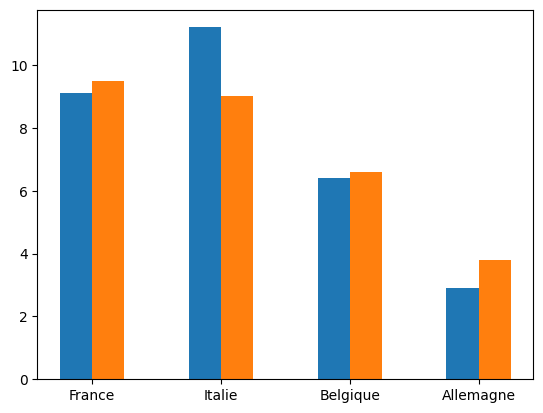

In [92]:
import matplotlib.pyplot as plt


pays = ["France", "Italie", "Belgique", "Allemagne"]
chomage_f = [9.1, 11.2, 6.4, 2.9]
chomage_h = [9.5, 9, 6.6, 3.8]
# Position sur l'axe des x pour chaque étiquette
position = np.arange(len(pays))
# Largeur des barres
largeur = .25
print(position)
# Création de la figure et d'un set de sous-graphiques
fig, ax = plt.subplots()
r1 = ax.bar(position - largeur/2, chomage_f, largeur)
r2 = ax.bar(position + largeur/2, chomage_h, largeur)

# Modification des marques sur l'axe des x et de leurs étiquettes
ax.set_xticks(position)
ax.set_xticklabels(pays)

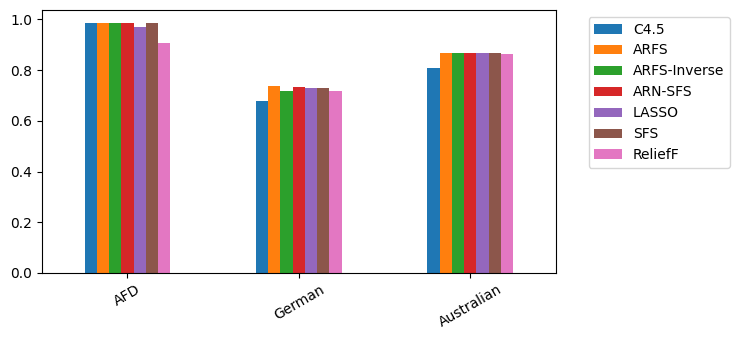

In [131]:
import pandas as pd
from pandas import plotting

#AFD = [0.9844, 0.9874, 0.9855, 0.9874, 0.9688, 0.9874, 0.9059] 
#German = [0.6799, 0.7390, 0.718, 0.734, 0.728, 0.728, 0.718] 
#Australian = [0.8072, 0.8666, 0.8666, 0.8666, 0.8666, 0.8666, 0.8623] 

CART = [0.9844, 0.6799, 0.8072]
ARFS = [0.9874, 0.7390, 0.8666]
ARFS_inverse = [0.9855, 0.718, 0.8666]
ARN_SFS = [0.9874, 0.734, 0.8666]
lasso = [0.9688, 0.728, 0.8666]
sfs = [0.9874, 0.728, 0.8666]
relief = [0.9059, 0.718, 0.8623]

mydata = pd.DataFrame({"C4.5": CART, "ARFS": ARFS, "ARFS-Inverse": ARFS_inverse, "ARN-SFS": ARN_SFS, "LASSO": lasso,
                      "SFS": sfs, "ReliefF": relief})

mydata.index = ['AFD', 'German', 'Australian'] 

#mydata = pd.DataFrame({"AFD": AFD, "German": German, "Australian": Australian})

#mydata.index = ['CART', 'ARFS', 'ARFS-Inverse', 'ARN-SFS', 'LASSO', 'SFS', 'ReliefF'] 

mydata.plot(kind="bar",rot=30) # Cette fonction fabrique automatiquement un diagramme à barres regroupées à partir d'une dataframe (rot : orientation des étiquettes)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("output-1.png", bbox_inches='tight')
plt.show()

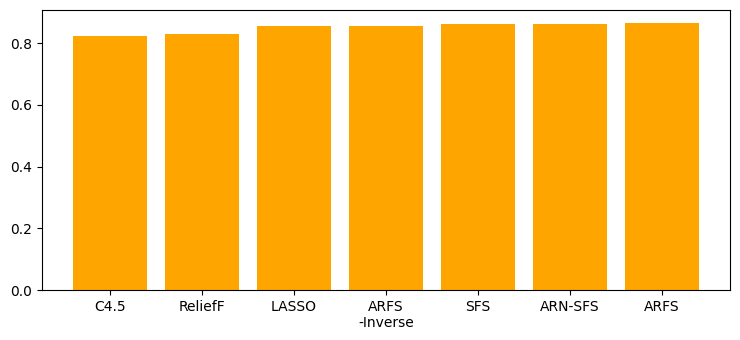

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True
df = pd.DataFrame(
    dict(
        Algorithme = ["C4.5", "ARFS", "ARFS\n-Inverse", "ARN-SFS", "LASSO", "SFS", "ReliefF"],
        Accuracy = [0.8238, 0.8643, 0.8567, 0.8626, 0.8544, 0.8606, 0.8287]
    )
)
df_sorted= df.sort_values('Accuracy')
plt.bar('Algorithme', "Accuracy", data=df_sorted, color="orange")
plt.savefig("Means_Accuracy_Algorithme.png")
plt.show()

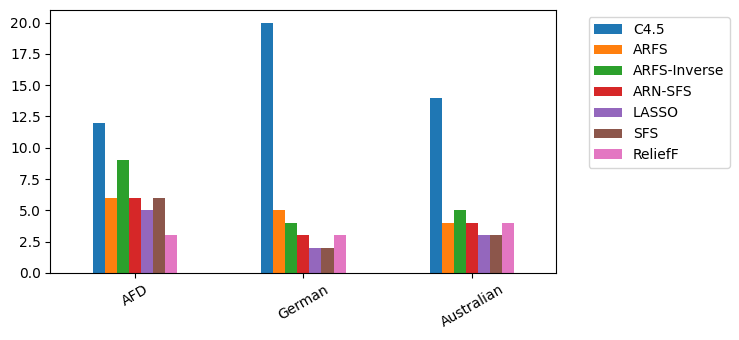

In [129]:
import pandas as pd
from pandas import plotting

#AFD = [0.9844, 0.9874, 0.9855, 0.9874, 0.9688, 0.9874, 0.9059] 
#German = [0.6799, 0.7390, 0.718, 0.734, 0.728, 0.728, 0.718] 
#Australian = [0.8072, 0.8666, 0.8666, 0.8666, 0.8666, 0.8666, 0.8623] 

CART = [12, 20, 14]
ARFS = [6, 5, 4]
ARFS_inverse = [9, 4, 5]
ARN_SFS = [6, 3, 4]
lasso = [5, 2, 3]
sfs = [6, 2, 3]
relief = [3, 3, 4]

mydata = pd.DataFrame({"C4.5": CART, "ARFS": ARFS, "ARFS-Inverse": ARFS_inverse, "ARN-SFS": ARN_SFS, "LASSO": lasso,
                      "SFS": sfs, "ReliefF": relief})

mydata.index = ['AFD', 'German', 'Australian'] 

#mydata = pd.DataFrame({"AFD": AFD, "German": German, "Australian": Australian})

#mydata.index = ['CART', 'ARFS', 'ARFS-Inverse', 'ARN-SFS', 'LASSO', 'SFS', 'ReliefF'] 

mydata.plot(kind="bar",rot=30) # Cette fonction fabrique automatiquement un diagramme à barres regroupées à partir d'une dataframe (rot : orientation des étiquettes)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("output-2.png", bbox_inches='tight')
plt.show()

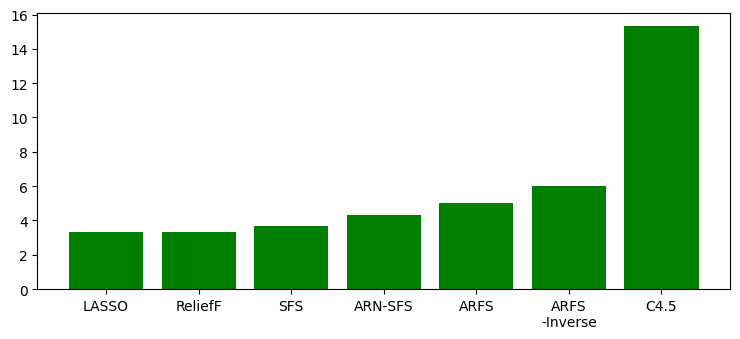

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True
df = pd.DataFrame(
    dict(
        Algorithme = ["C4.5", "ARFS", "ARFS\n-Inverse", "ARN-SFS", "LASSO", "SFS", "ReliefF"],
        NumberFeat = [15.33, 5, 6, 4.33, 3.33, 3.66, 3.33]
    )
)
df_sorted= df.sort_values('NumberFeat')
plt.bar('Algorithme', "NumberFeat", data=df_sorted, color="green")
plt.savefig("Means_Numb_Features.png")
plt.show()

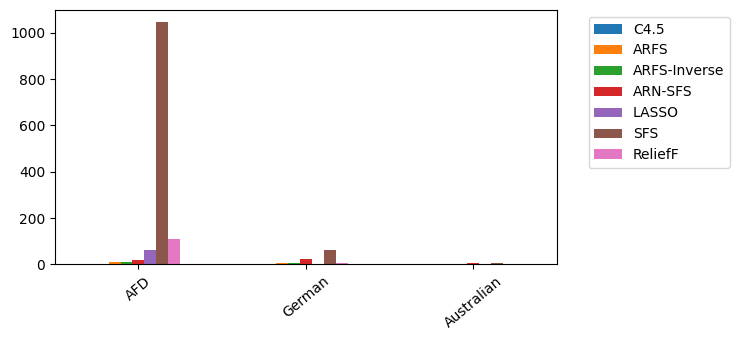

In [127]:
import pandas as pd
from pandas import plotting

#AFD = [0.9844, 0.9874, 0.9855, 0.9874, 0.9688, 0.9874, 0.9059] 
#German = [0.6799, 0.7390, 0.718, 0.734, 0.728, 0.728, 0.718] 
#Australian = [0.8072, 0.8666, 0.8666, 0.8666, 0.8666, 0.8666, 0.8623] 

CART = [2.2251, 0.1614 , 0.0952]
ARFS = [10.7438, 5.5818, 1.5854]
ARFS_inverse = [11.5899, 7.4492, 1.5493]
ARN_SFS = [18.7290, 24.8614, 4.1031]
lasso = [60.4453, 2.5496, 0.7868]
sfs = [1046.1553, 61.0102, 5.1702]
relief = [110.5407, 5.4915, 2.4859]

mydata = pd.DataFrame({"C4.5": CART, "ARFS": ARFS, "ARFS-Inverse": ARFS_inverse, "ARN-SFS": ARN_SFS, "LASSO": lasso,
                      "SFS": sfs, "ReliefF": relief})

mydata.index = ['AFD', 'German', 'Australian'] 

#mydata = pd.DataFrame({"AFD": AFD, "German": German, "Australian": Australian})

#mydata.index = ['CART', 'ARFS', 'ARFS-Inverse', 'ARN-SFS', 'LASSO', 'SFS', 'ReliefF'] 

mydata.plot(kind="bar",rot=40) # Cette fonction fabrique automatiquement un diagramme à barres regroupées à partir d'une dataframe (rot : orientation des étiquettes)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("output-3.png", bbox_inches='tight')
plt.show()

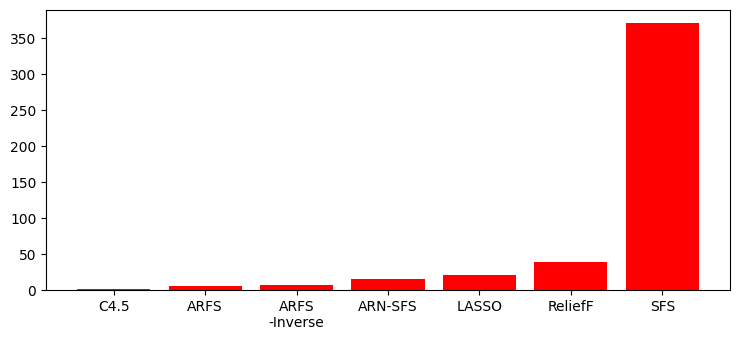

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True
df = pd.DataFrame(
    dict(
        Algorithme = ["C4.5", "ARFS", "ARFS\n-Inverse", "ARN-SFS", "LASSO", "SFS", "ReliefF"],
        RunTime = [0.8272, 5.9703, 6.8628, 15.8978, 21.2605, 370.7785, 39.5060]
    )
)
df_sorted= df.sort_values('RunTime')
plt.bar('Algorithme', "RunTime", data=df_sorted, color="red")
plt.savefig("Means_RunTime_Algorithme.png")
plt.show()

In [2]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.887 (0.030)


In [5]:
def feature_selection_MI(dataset, model, max_features_val, scoring_val, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    for max_feat in range(1, max_features_val + 1):        
        fs = SelectKBest(mutual_info_classif, k=max_feat)
        X_train_new = fs.fit_transform(np.array(X_train), np.array(y_train))

        #pos = pd.DataFrame(fs.feature_scores.reshape(-1,1)).sort_values(by=0, ascending=False).head(max_feat).index.tolist()
        #column_selected = [columns_extract_all[i] for i in pos]
        
        cols = fs.get_support(indices=True)
        column_selected = X_train.iloc[:,cols].columns.tolist()

        
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
            set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))
            
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected


def feature_selection_RFE_SVM(dataset, model, max_features_val, scoring_val, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    for max_feat in range(1, max_features_val + 1):
        print(max_feat)
        fs = SVR(kernel="linear")
        fs = RFE(fs, n_features_to_select=max_feat, step=1)
        X_train_new = fs.fit(np.array(X_train), np.array(y_train))
        support = fs.support_
        column_selected = [columns_extract_all[i] for i in range(len(support)) if support[i] == True]
        
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
            set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))
            
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected




def feature_selection_RFE_SVM_(dataset, model, max_features_val, scoring_val, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    fs = SVR(kernel="linear")
    fs = RFE(fs, n_features_to_select=max_features_val, step=1)
    X_train_new = fs.fit(np.array(X_train), np.array(y_train))
    support = fs.support_
    column_selected = [columns_extract_all[i] for i in range(len(support)) if support[i] == True]

    feature_selected = []
    for feature in column_selected:
        if feature in columns:
            feature_selected.append(feature)
        else:
            feature_x = feature.split(sep)[0]
            feature_selected.append(feature_x)
    feature_selected = list(set(feature_selected))

    X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
    model.fit(X_train_selected, y_train)
    X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
    y_data = np.concatenate((y_train, y_test), axis=0)

    means_scores = []
    for score_i in scoring_val:
        scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
        means_scores.append(np.mean(scores)) 
        set_feature_selected[max_features_val] = (feature_selected, deepcopy(means_scores))
            
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected





def feature_selection_ridge(dataset, model, max_features_val, scoring_val, n_neighbors, name_classe, sep, random):
    columns = dataset.columns.tolist()
    columns = list(set(columns) - set([name_classe]))
    X_train, X_test, y_train, y_test, columns_extract_all = preprocessing_dataset_(dataset, [name_classe], sep, name_classe, random)    
    #X_train_tr = X_train.values.tolist()
    set_feature_selected = dict()
    #print(X_train_tr)
    #print(y_train)
    for max_feat in range(1, max_features_val + 1):
        fs = Ridge(alpha=1.0)
        fs.fit(np.array(X_train),np.array(y_train))
        
        
        pos = pd.DataFrame(fs.coef_.reshape(-1,1)).sort_values(by=0, ascending=False).head(max_feat).index.tolist()
        column_selected = [columns_extract_all[i] for i in pos]
        feature_selected = []
        for feature in column_selected:
            if feature in columns:
                feature_selected.append(feature)
            else:
                feature_x = feature.split(sep)[0]
                feature_selected.append(feature_x)
        feature_selected = list(set(feature_selected))

        X_train_selected, X_test_selected, columns_extract = selected_dataset_(columns_extract_all, feature_selected, sep, X_train, X_test)
        model.fit(X_train_selected, y_train)
        X_data = np.concatenate((X_train_selected, X_test_selected), axis=0)
        y_data = np.concatenate((y_train, y_test), axis=0)
        means_scores = []
        for score_i in scoring_val:
            scores = cross_val_score(model, X=X_data, y=y_data, cv=10, scoring=score_i, n_jobs=1)
            means_scores.append(np.mean(scores)) 
            set_feature_selected[max_feat] = (feature_selected, deepcopy(means_scores))    
    set_feature_selected = sorted(set_feature_selected.items(), key=lambda x:x[1][1], reverse=True)
    return set_feature_selected
import sklearn
print(sklearn.__version__)

1.3.0


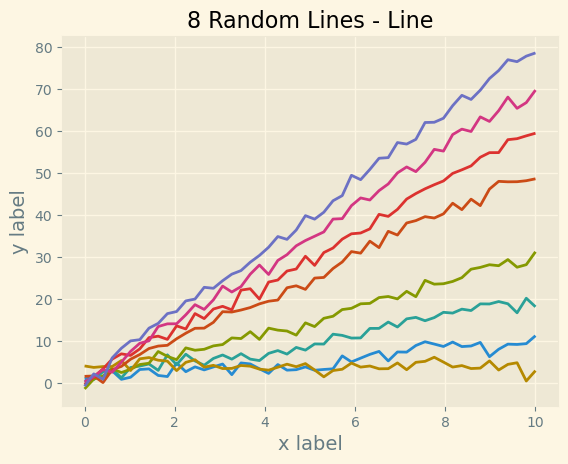

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

x = np.linspace(0, 10)
with plt.style.context('Solarize_Light2'):
    plt.plot(x, np.sin(x) + x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 2 * x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 3 * x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 4 + np.random.randn(50))
    plt.plot(x, np.sin(x) + 5 * x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 6 * x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 7 * x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 8 * x + np.random.randn(50))
    # Number of accent colors in the color scheme
    plt.title('8 Random Lines - Line')
    plt.xlabel('x label', fontsize=14)
    plt.ylabel('y label', fontsize=14)

plt.show()